# Modelos

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from itertools import combinations
from scipy import stats
from statsmodels import graphics,tsa
from statsmodels.tsa import stattools
import statsmodels.graphics.tsaplots as tsp
import statsmodels.api as sm

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [2]:
delitos = pd.read_csv("tabla_completa_michoacan.csv") 
delitos

,Fecha,"('Acuitzio_Homicidio_Homicidio doloso_Con arma de fuego',)","('Acuitzio_Homicidio_Homicidio doloso_Con arma blanca',)","('Acuitzio_Homicidio_Homicidio doloso_Con otro elemento',)","('Acuitzio_Homicidio_Homicidio doloso_No especificado',)","('Acuitzio_Homicidio_Homicidio culposo_Con arma de fuego',)","('Acuitzio_Homicidio_Homicidio culposo_Con arma blanca',)","('Acuitzio_Homicidio_Homicidio culposo_En accidente de tránsito',)","('Acuitzio_Homicidio_Homicidio culposo_Con otro elemento',)","('Acuitzio_Homicidio_Homicidio culposo_No especificado',)",...,"('José Sixto Verduzco_Narcomenudeo_Narcomenudeo_Narcomenudeo',)","('José Sixto Verduzco_Amenazas_Amenazas_Amenazas',)","('José Sixto Verduzco_Allanamiento de morada_Allanamiento de morada_Allanamiento de morada',)","('José Sixto Verduzco_Evasión de presos_Evasión de presos_Evasión de presos',)","('José Sixto Verduzco_Falsedad_Falsedad_Falsedad',)","('José Sixto Verduzco_Falsificación_Falsificación_Falsificación',)","('José Sixto Verduzco_Contra el medio ambiente_Contra el medio ambiente_Contra el medio ambiente',)","('José Sixto Verduzco_Delitos cometidos por servidores públicos_Delitos cometidos por servidores públicos_Delitos cometidos por servidores públicos',)","('José Sixto Verduzco_Electorales_Electorales_Electorales',)","('José Sixto Verduzco_Otros delitos del Fuero Común_Otros delitos del Fuero Común_Otros delitos del Fuero Común',)"
0,2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,2015-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2015-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2021-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,2021-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


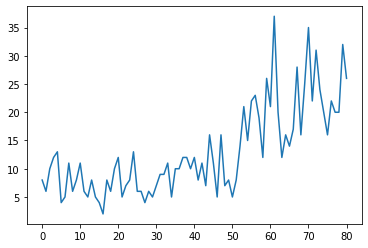

In [3]:
serie_morelia = delitos.iloc[:,5097][:-3]
plt.plot(serie_morelia)

## Forescasting autorregresivo recursivo.

Fechas train : 0 --- 40  (n=41)
Fechas test  : 41 --- 80  (n=40)


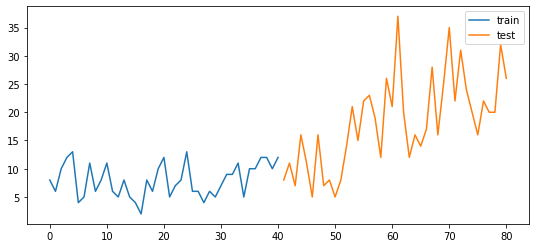

In [4]:
# ==============================================================================
steps = 40
datos_train = serie_morelia[:-steps]
datos_test  = serie_morelia[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [5]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 40] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-02 19:01:34 
Last fit date: 2022-09-02 19:01:34 
Skforecast version: 0.4.3 

In [6]:
# Predicciones
# ==============================================================================
steps = 40
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

41    10.79
42     9.95
43    10.28
44    11.41
45     9.69
Name: pred, dtype: float64

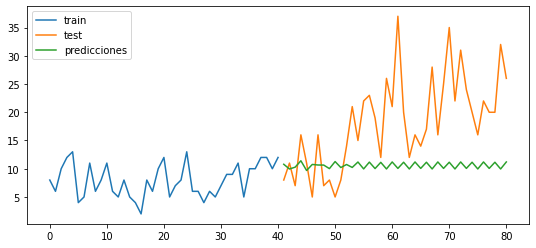

In [7]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [8]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 122.3060375


### Mismo ejemplo pero con serie de diferencias.

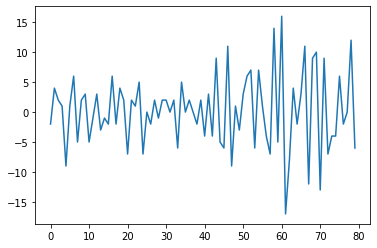

In [9]:
ejemplo2 = np.array(serie_morelia)
d = ejemplo2[1:]-ejemplo2[0:-1]
d_series = pd.Series(d)
plt.plot(d_series)

Fechas train : 0 --- 39  (n=40)
Fechas test  : 40 --- 79  (n=40)


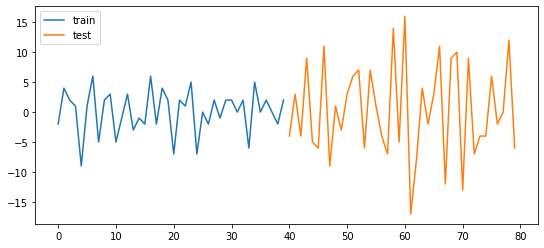

In [10]:
# ==============================================================================
steps = 40
datos_train = d_series[:-steps]
datos_test  = d_series[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [11]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 39] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-02 19:01:36 
Last fit date: 2022-09-02 19:01:36 
Skforecast version: 0.4.3 

In [12]:
# Predicciones
# ==============================================================================
steps = 40
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

40   -1.14
41    2.28
42   -1.36
43    2.04
44    0.77
Name: pred, dtype: float64

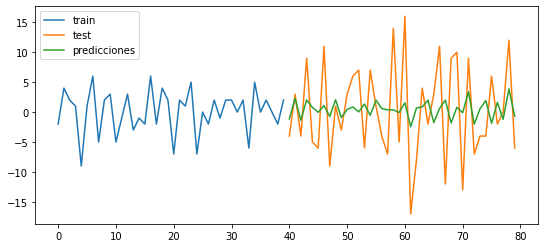

In [13]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [14]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 57.046505


## Modelo ARIMA

In [15]:
ejem = pd.DataFrame(d_series)
ejem

,0
0,-2.0
1,4.0
2,2.0
3,1.0
4,-9.0
...,...
75,6.0
76,-2.0
77,0.0
78,12.0


In [16]:
# Modelo ARIMA

model_arima = auto_arima(ejem[0], 
                        start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',  
                          suppress_warnings = True, 
                          stepwise = True)          
  
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=486.365, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=459.102, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=484.400, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=471.077, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=457.474, Time=0.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=477.839, Time=0.18 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=453.024, Time=0.39 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=455.935, Time=0.14 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=452.859, Time=0.47 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=450.933, Time=0.18 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   80
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -217.453
Date:                            Fri, 02 Sep 2022   AIC                            440.905
Time:                                    19:01:58   BIC                            447.564
Sample:                                         0   HQIC                           443.544
                                             - 80                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7666      0.083     -9.217      0.000      -0.930      -0.604
ma.S.L12      -0.8730      0.365     -2.393      0.017      -1.588      -0.158
sigma2        27.7208      8.933      3.103      0.002      10.213      45.228
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.55
Prob(Q):                              0.96   Prob(JB):                         0.01
Heteroskedasticity (H):               3.81   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
steps = 36
datos_train = ejem[:-steps]
datos_test  = ejem[-steps:]

model = SARIMAX(datos_train[0],
                order = (0, 0, 1), 
                seasonal_order =(2, 1, 0, 12))

result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10713D+00    |proj g|=  5.08670D-02

At iterate    5    f=  2.08554D+00    |proj g|=  1.10938D-03

At iterate   10    f=  2.08554D+00    |proj g|=  1.20872D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.209D-06   2.086D+00
  F =   2.0855362413199994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                 -91.764
Date:                             Fri, 02 Sep 2022   AIC                            191.527
Time:                                     19:01:58   BIC                            197.390
Sample:                                          0   HQIC                           193.471
                                              - 44                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8032      0.179     -4.488      0.000      -1.154      -0.452
ar.S.L12      -0.6535      0.515     -1.269      0.204      -1.663       0.356
ar.S.L24      -0.3445      0.326     -1.055      0.291      -0.984       0.295
sigma2        14.3865      7.820      1.840      0.066      -0.941      29.714
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.66   Prob(JB):                         0.66
Heteroskedasticity (H):               0.69   Skew:                            -0.06
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

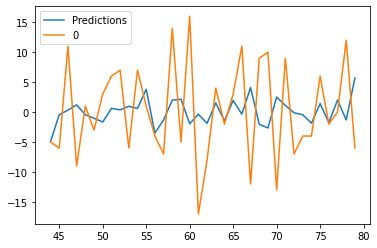

In [18]:
start = len(datos_train)
end = len(datos_train) + len(datos_test) - 1
  
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
predictions.plot(legend = True)
datos_test[0].plot(legend = True)

In [19]:
mean_squared_error(datos_test[0], predictions)

74.85213748560665

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79951D+00    |proj g|=  7.03728D-02

At iterate    5    f=  2.73439D+00    |proj g|=  2.20947D-02

At iterate   10    f=  2.73334D+00    |proj g|=  9.84794D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   9.848D-06   2.733D+00
  F =   2.7333411043274167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<AxesSubplot:>

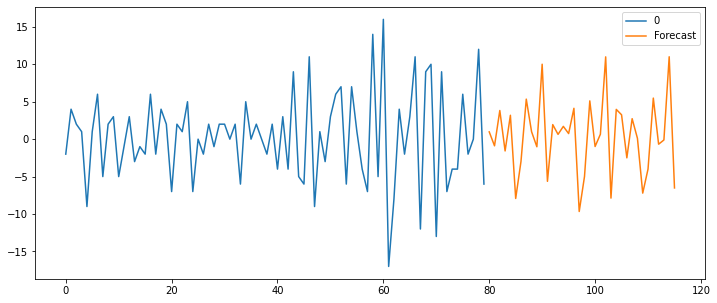

In [20]:
model = model = SARIMAX(ejem[0], 
                        order = (0, 0, 1), 
                        seasonal_order =(2, 1, 0, 12))
result = model.fit()
  
forecast = result.predict(start = len(ejem), 
                          end = (len(ejem)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')
  
ejem[0].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [21]:
mean_squared_error(datos_test[0], predictions)

74.85213748560665

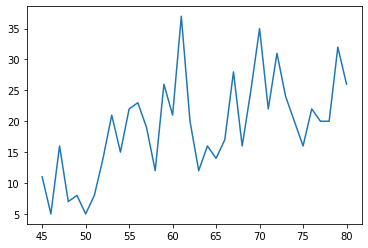

In [22]:
datos_test = serie_morelia[-steps:]
plt.plot(datos_test)

In [23]:
datos_test_n = np.array((datos_test))

<AxesSubplot:>

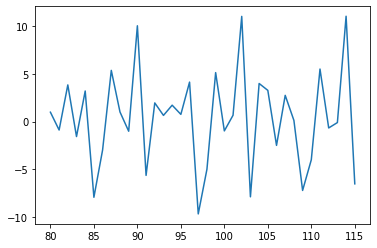

In [24]:
forecast.plot()

In [25]:
forecast_n = np.array(forecast)

In [26]:
reales = datos_test_n + forecast_n

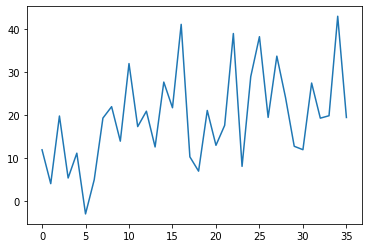

In [27]:
plt.plot(reales)

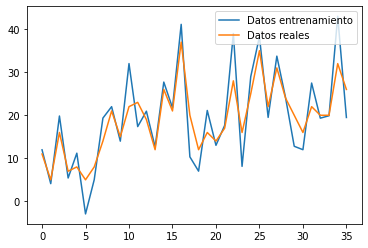

In [28]:
plt.plot(reales)
plt.plot(datos_test_n)
plt.legend(["Datos entrenamiento", "Datos reales"], loc ="upper right")

## Red neuronal

In [29]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense

2022-09-02 19:02:02.209321: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-02 19:02:02.213632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-02 19:02:02.213646: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [30]:
# Dividir serie
def dividir_serie(serie, n_pasos):
    X, y = list(), list()
    for i in range(len(serie)):
        fin_ix = i + n_pasos

        if fin_ix > len(serie)-1:
            break
        # entrada y salida
        ser_x, ser_y = serie[i:fin_ix], serie[fin_ix]
        X.append(ser_x)
        y.append(ser_y)
    
    return array(X), array(y)

In [31]:
dividir_serie(d_series, 6)

(array([[ -2.,   4.,   2.,   1.,  -9.,   1.],
        [  4.,   2.,   1.,  -9.,   1.,   6.],
        [  2.,   1.,  -9.,   1.,   6.,  -5.],
        [  1.,  -9.,   1.,   6.,  -5.,   2.],
        [ -9.,   1.,   6.,  -5.,   2.,   3.],
        [  1.,   6.,  -5.,   2.,   3.,  -5.],
        [  6.,  -5.,   2.,   3.,  -5.,  -1.],
        [ -5.,   2.,   3.,  -5.,  -1.,   3.],
        [  2.,   3.,  -5.,  -1.,   3.,  -3.],
        [  3.,  -5.,  -1.,   3.,  -3.,  -1.],
        [ -5.,  -1.,   3.,  -3.,  -1.,  -2.],
        [ -1.,   3.,  -3.,  -1.,  -2.,   6.],
        [  3.,  -3.,  -1.,  -2.,   6.,  -2.],
        [ -3.,  -1.,  -2.,   6.,  -2.,   4.],
        [ -1.,  -2.,   6.,  -2.,   4.,   2.],
        [ -2.,   6.,  -2.,   4.,   2.,  -7.],
        [  6.,  -2.,   4.,   2.,  -7.,   2.],
        [ -2.,   4.,   2.,  -7.,   2.,   1.],
        [  4.,   2.,  -7.,   2.,   1.,   5.],
        [  2.,  -7.,   2.,   1.,   5.,  -7.],
        [ -7.,   2.,   1.,   5.,  -7.,   0.],
        [  2.,   1.,   5.,  -7.,  

In [32]:
d_series

0     -2.0
1      4.0
2      2.0
3      1.0
4     -9.0
      ... 
75     6.0
76    -2.0
77     0.0
78    12.0
79    -6.0
Length: 80, dtype: float64

In [33]:
d_series.tail(6)

74    -4.0
75     6.0
76    -2.0
77     0.0
78    12.0
79    -6.0
dtype: float64

In [34]:
def red_neuronal(serie, cant_div, n_pasos, activa):
    # Serie de tiempo
    serie_aPred = serie

    # Dividir serie
    X, y = dividir_serie(serie_aPred, n_pasos)

    X_train = X[:cant_div]
    y_train = y[:cant_div]
    X_test = X[cant_div:]
    y_test = y[cant_div:]
    y_test_navie = y[cant_div-1:-1]

    # Definir modelo
    model = Sequential()
    model.add(Dense(10, activation=activa, input_dim=n_pasos))
    model.add(Dense(10, activation=activa, input_dim=10))
    model.add(Dense(10, activation=activa, input_dim=10))
    model.add(Dense(10, activation=activa, input_dim=10))
    model.add(Dense(1, activation=activa, input_dim=10))
    model.compile(optimizer='adam', loss='mse')

    # Entrenar modelo
    model.fit(X_train, y_train, epochs=2000, verbose=0)
    
    # Mostrar predicciones
    x_input = array([[0, 2, 1, 1, 0, 1]])
    #x_input = x_input.reshape((1, n_pasos))
    yhat = model.predict(X_test, verbose=0)

    print("El siguiente mes tendra: ", yhat)
    
    plt.plot(yhat)
    plt.plot(y_test)
    plt.legend(["Datos entrenamiento", "Datos reales"], loc ="upper right")
    
    #error
    error = np.average(np.abs(yhat-y_test))
    print("El error es de: ", error)

2022-09-02 19:02:04.492594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-02 19:02:04.492648: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-02 19:02:04.492673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cgeoqro): /proc/driver/nvidia/version does not exist
2022-09-02 19:02:04.493090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


El siguiente mes tendra:  [[ 0.        ]
 [ 0.        ]
 [10.975579  ]
 [ 0.60355085]
 [ 6.8170886 ]
 [ 0.        ]
 [ 2.8184302 ]
 [18.149012  ]
 [16.72063   ]
 [10.381314  ]
 [ 0.        ]]
El error es de:  9.612640436523217


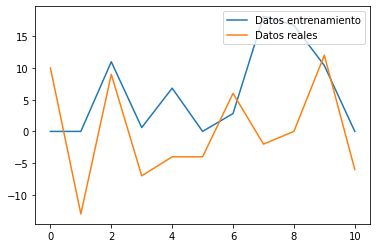

In [35]:
red_neuronal(d_series, 63, 6, 'relu')

El siguiente mes tendra:  [[5.5829552e-04]
 [5.4389721e-04]
 [9.9871957e-01]
 [7.2679366e-04]
 [9.7824258e-01]
 [9.9715561e-01]
 [9.9861300e-01]
 [9.9501604e-01]
 [9.9873048e-01]
 [9.9854648e-01]
 [5.4336345e-04]]
El error es de:  6.809108994360474


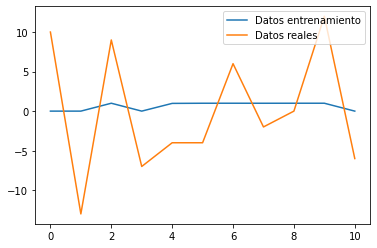

In [36]:
red_neuronal(d_series, 63, 6, 'sigmoid')

### Ejemplo con todos los delitos de Abasolo

In [37]:
todos_abasolo = delitos.iloc[:, 1:99][:-3]
todos_abasolo

,"('Acuitzio_Homicidio_Homicidio doloso_Con arma de fuego',)","('Acuitzio_Homicidio_Homicidio doloso_Con arma blanca',)","('Acuitzio_Homicidio_Homicidio doloso_Con otro elemento',)","('Acuitzio_Homicidio_Homicidio doloso_No especificado',)","('Acuitzio_Homicidio_Homicidio culposo_Con arma de fuego',)","('Acuitzio_Homicidio_Homicidio culposo_Con arma blanca',)","('Acuitzio_Homicidio_Homicidio culposo_En accidente de tránsito',)","('Acuitzio_Homicidio_Homicidio culposo_Con otro elemento',)","('Acuitzio_Homicidio_Homicidio culposo_No especificado',)","('Acuitzio_Lesiones_Lesiones dolosas_Con arma de fuego',)",...,"('Acuitzio_Narcomenudeo_Narcomenudeo_Narcomenudeo',)","('Acuitzio_Amenazas_Amenazas_Amenazas',)","('Acuitzio_Allanamiento de morada_Allanamiento de morada_Allanamiento de morada',)","('Acuitzio_Evasión de presos_Evasión de presos_Evasión de presos',)","('Acuitzio_Falsedad_Falsedad_Falsedad',)","('Acuitzio_Falsificación_Falsificación_Falsificación',)","('Acuitzio_Contra el medio ambiente_Contra el medio ambiente_Contra el medio ambiente',)","('Acuitzio_Delitos cometidos por servidores públicos_Delitos cometidos por servidores públicos_Delitos cometidos por servidores públicos',)","('Acuitzio_Electorales_Electorales_Electorales',)","('Acuitzio_Otros delitos del Fuero Común_Otros delitos del Fuero Común_Otros delitos del Fuero Común',)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
77,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
todos_abasolo_chido = todos_abasolo.to_numpy().flatten(order='f')

In [39]:
def crear_diferencias(serie):
    serie_ori = np.array(serie)
    d = serie_ori[1:] - serie_ori[0:-1]
    dif = pd.Series(d)
    plt.plot(dif)
    
    return dif

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7932   -1.0
7933    2.0
7934   -2.0
7935    1.0
7936   -1.0
Length: 7937, dtype: float64

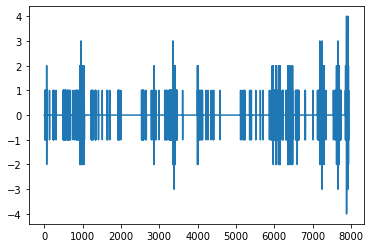

In [46]:
diferencias_abasolo = crear_diferencias(todos_abasolo_chido)
diferencias_abasolo

El siguiente mes tendra:  [[0.14730823]
 [0.14800106]
 [0.00187031]
 ...
 [0.00171739]
 [0.14656754]
 [0.00171608]]
El error es de:  0.22227062686795948


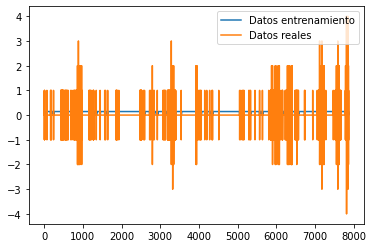

In [43]:
red_neuronal(diferencias_abasolo, 63, 6, 'sigmoid')